In [1]:
import os, glob
import numpy as np
import pandas as pd
from calendar import monthrange,month_name
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
%matplotlib inline
fs = 18
plt.rc('font', family='serif')
plt.rc('font', size=18)

In [3]:
# date parser for pandas
dp = lambda x: pd.datetime.strptime(x,'%d-%m-%Y %H:%M:%S')

In [4]:
# paths (must mount volume smb://nrel.gov/shared/wind/WindWeb/MetData/135mData/M5Twr)
# metPathLoHz = '/Volumes/M5Twr/10min/txt/'
metPathLoHz = '/Volumes/shared/Wind/WindWeb/MetData/135mData/M5Twr/10min/txt/'

In [5]:
# time range
# year1 = [2012]
# year2 = [2017]
# years = [np.arange(year1,year2+1,1)]
years = [2017]
months = [ int(a) for a in np.arange(1,12.1,1) ]

In [6]:
# read in data
filecount = 0
for year in years:
    for month in months:
        fName = glob.glob(os.path.join(metPathLoHz,'{0}_{1}.txt'.format(year,month_name[month])))        
        if len(fName)>0:
            fName = fName[0] ; print(fName)
            df_lo = pd.read_csv(fName,index_col=[0],parse_dates=[0],date_parser=dp,skiprows=[0,1,2,3,4,5,6,8,9],
                               low_memory=False)
            if filecount==0:
                df = df_lo.copy()
            else:
                df = df.append(df_lo.copy())
            filecount += 1
df.index = df.index.tz_localize('UTC').tz_convert('America/Denver')            

/Volumes/shared/Wind/WindWeb/MetData/135mData/M5Twr/10min/txt/2017_January.txt
/Volumes/shared/Wind/WindWeb/MetData/135mData/M5Twr/10min/txt/2017_February.txt
/Volumes/shared/Wind/WindWeb/MetData/135mData/M5Twr/10min/txt/2017_March.txt
/Volumes/shared/Wind/WindWeb/MetData/135mData/M5Twr/10min/txt/2017_April.txt
/Volumes/shared/Wind/WindWeb/MetData/135mData/M5Twr/10min/txt/2017_May.txt
/Volumes/shared/Wind/WindWeb/MetData/135mData/M5Twr/10min/txt/2017_June.txt
/Volumes/shared/Wind/WindWeb/MetData/135mData/M5Twr/10min/txt/2017_July.txt
/Volumes/shared/Wind/WindWeb/MetData/135mData/M5Twr/10min/txt/2017_August.txt
/Volumes/shared/Wind/WindWeb/MetData/135mData/M5Twr/10min/txt/2017_September.txt
/Volumes/shared/Wind/WindWeb/MetData/135mData/M5Twr/10min/txt/2017_October.txt
/Volumes/shared/Wind/WindWeb/MetData/135mData/M5Twr/10min/txt/2017_November.txt
/Volumes/shared/Wind/WindWeb/MetData/135mData/M5Twr/10min/txt/2017_December.txt


## Implement QC masking on input data (here on 10 minute bins)
Each data field is associated with a QC field <br>
- Extract data: dfField = [date, field, field QC]
- Create mask: mask = field QC == 1
- Filter data: dfFiltField = dfField[mask]

In [37]:
temp = [name for name in list(df.columns.values) if ' QC' not in name]
qcNames = [name for name in list(df.columns.values) if ' QC' in name]
fNames = [name for name in temp if name + ' QC' in qcNames]
print('number of data columns:', len(fNames))
print('number of QC columns:', len(qcNames))

number of data columns: 461
number of QC columns: 471


In [43]:
# initialize filtered dataframe with 'record', 'version'
dfFilt = df[df.columns.values[[0,1]]].copy()
# apply QC mask to each set of columns individually
for f, q in zip(fNames, qcNames):
#     print(fname, qname)
    temp = df[[f, q]]
    mask = temp[q] == 1
    temp = temp[mask]
#     dfFilt = pd.concat([dfFilt,temp], axis = 1)
    dfFilt[f] = temp[f]

In [47]:
# find and replace missing data (-999.0) with consistent nan values
dfFilt = dfFilt.replace(to_replace=-999.0, value=np.nan)
dfFilt.head()

,Record,Version,Input records,Valid records,Speed (cup_ 130 m),d(U)/d(t) (cup_ 130 m),Ti (cup_ 130 m),Direction (Vane_ 130 m),Std. Dev. Direction (Vane_ 130 m),Speed (cup_ 122 m),...,Boom peak velocity (y_ 15m),Boom RMS velocity (y_ 15m),Boom mean acceleration (z_ 15m),Boom RMS acceleration (z_ 15m),Boom peak velocity (z_ 15m),Boom RMS velocity (z_ 15m),Monin-Obukhov Length (15m),Stability parameter z/L (15m),Surface w'T',Height of w'T' (surface) (z)
Date,,,,,,,,,,,,,,,,,,,,,
2016-12-31 17:00:00-07:00,1,1.41,12000.0,12000.0,1.042673,-0.000413,20.556453,NaN,NaN,0.701986,...,0.0,0.0,-5.697929,5.719041,0.000001,0.0,19.737151,0.759988,-0.001218,15.0
2016-12-31 17:10:00-07:00,2,1.41,12000.0,12000.0,0.624622,-0.000694,50.554621,NaN,NaN,0.128961,...,0.0,0.0,-5.019179,5.053237,0.000001,0.0,-2558.676310,-0.005862,0.000021,15.0
2016-12-31 17:20:00-07:00,3,1.41,12000.0,12000.0,0.380387,-0.000266,64.716807,NaN,NaN,0.000000,...,0.0,0.0,-4.354442,4.383229,0.000001,0.0,35.547158,0.421975,-0.001542,15.0
2016-12-31 17:30:00-07:00,4,1.41,12000.0,12000.0,0.303401,0.001288,86.200003,NaN,NaN,0.000000,...,0.0,0.0,-4.347116,4.379091,0.000001,0.0,1.811492,8.280466,-0.000157,15.0
2016-12-31 17:40:00-07:00,5,1.41,12000.0,12000.0,1.257596,0.003006,42.173407,NaN,NaN,1.100326,...,0.0,0.0,-4.179537,4.209621,0.000001,0.0,-44.681464,-0.335710,0.001233,15.0


In [48]:
# Sort data by hour, produces a single diurnal cycle
diurnal_cycle = dfFilt.groupby(dfFilt.index.hour).mean()
diurnal_cycle.columns

Index(['Record', 'Version', 'Input records', 'Valid records',
       'Speed (cup_ 130 m)', 'd(U)/d(t) (cup_ 130 m)', 'Ti (cup_ 130 m)',
       'Direction (Vane_ 130 m)', 'Std. Dev. Direction (Vane_ 130 m)',
       'Speed (cup_ 122 m)',
       ...
       'Boom peak velocity (y_ 15m)', 'Boom RMS velocity (y_ 15m)',
       'Boom mean acceleration (z_ 15m)', 'Boom RMS acceleration (z_ 15m)',
       'Boom peak velocity (z_ 15m)', 'Boom RMS velocity (z_ 15m)',
       'Monin-Obukhov Length (15m)', 'Stability parameter z/L (15m)',
       'Surface w'T'', 'Height of w'T' (surface) (z)'],
      dtype='object', length=456)

In [105]:
monthly_diurnal_cycle = dfFilt.groupby([dfFilt.index.month, dfFilt.index.hour]).mean()


In [106]:
# find all data produced by cup anemometers from the 
# spdcols = diurnal_cycle.columns
spdcols = [col for col in diurnal_cycle.columns.values if'Speed' in col and 'cup' in col]
print(spdcols)

['Speed (cup_ 130 m)', 'Speed (cup_ 122 m)', 'Speed (cup_ 105 m)', 'Speed (cup_ 87 m)', 'Speed (cup_ 80 m)', 'Speed (cup_ 55 m)', 'Speed (cup_ 38 m)', 'Speed (cup_ 30 m)', 'Speed (cup_ 10 m)', 'Speed (cup_ 3 m)']


In [107]:
diurnal_cycle[spdcols].describe()

,Speed (cup_ 130 m),Speed (cup_ 122 m),Speed (cup_ 105 m),Speed (cup_ 87 m),Speed (cup_ 80 m),Speed (cup_ 55 m),Speed (cup_ 38 m),Speed (cup_ 30 m),Speed (cup_ 10 m),Speed (cup_ 3 m)
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,5.041049,4.836289,4.862082,4.690991,4.817923,4.727224,4.403993,4.450384,3.689552,2.788112
std,0.220445,0.212810,0.217807,0.210579,0.217862,0.199622,0.207653,0.190323,0.214347,0.281556
min,4.633620,4.419912,4.439208,4.259228,4.378066,4.291834,3.968606,4.037663,3.347132,2.502755
25%,4.917636,4.699274,4.742258,4.545267,4.682081,4.623144,4.293572,4.345982,3.566137,2.593121
50%,5.101110,4.882657,4.946027,4.727947,4.882084,4.761526,4.421278,4.470886,3.640540,2.628823
75%,5.185301,4.979414,5.021241,4.814943,4.963296,4.839348,4.493763,4.542400,3.799114,3.071656
max,5.426838,5.239878,5.231880,5.090340,5.214399,5.086573,4.781979,4.795818,4.080447,3.264758


Text(0.5,1,'Hourly average')

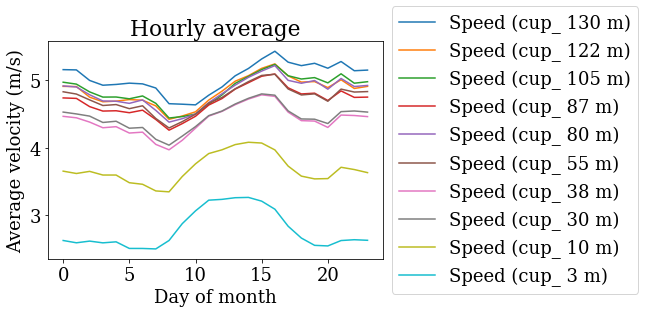

In [108]:
ax = diurnal_cycle[spdcols].plot()
plt.legend( loc='center left', bbox_to_anchor=(1,0.5))
plt.xlabel('Day of month')
plt.ylabel('Average velocity (m/s)')
handles, labels = ax.get_legend_handles_labels()
plt.title('Hourly average')


In [104]:
#temp = monthly_diurnal_cycle['Speed (cup_ 80 m)'].xs(month)
#temp.describe()
monthly_diurnal_cycle.index.values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

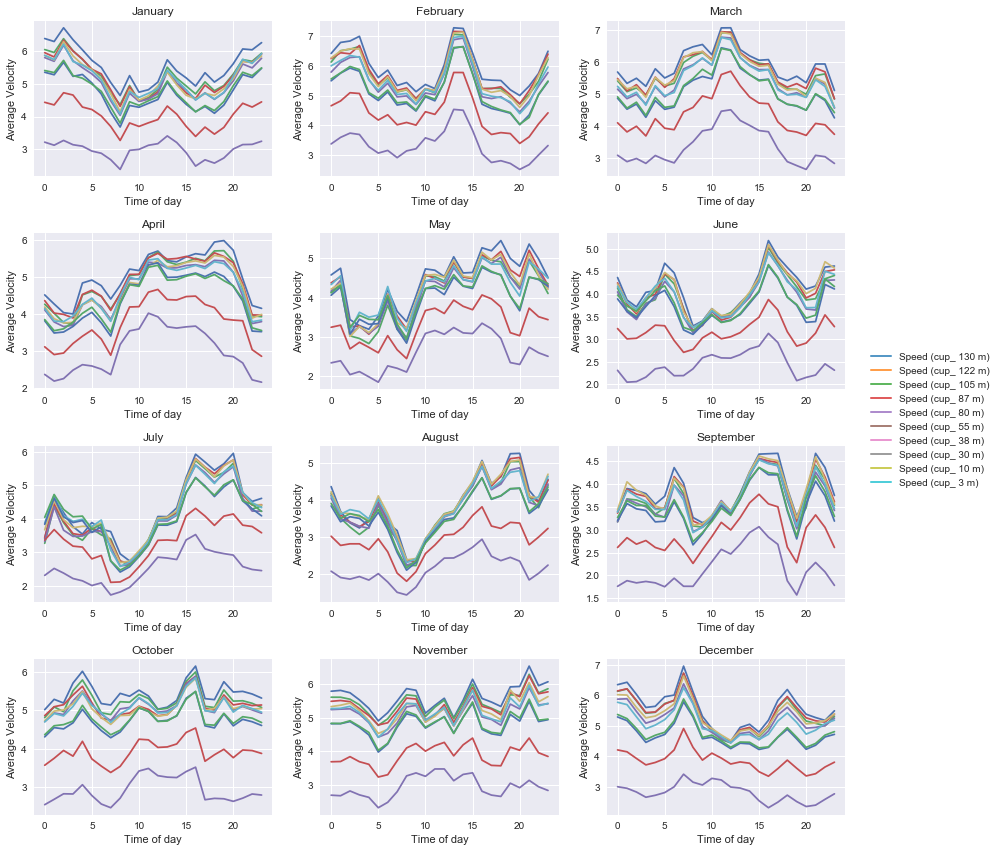

In [122]:
fig = plt.figure(figsize=(12,12))
for month in months:
    plt.subplot(4, 3, month)
    ax = plt.plot( monthly_diurnal_cycle[spdcols].xs(month))
    plt.xlabel('Time of day')
    plt.ylabel('Average Velocity')
    plt.title(month_name[month])
#     handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.15, 0.5), borderaxespad=0., ncol=1)
fig.tight_layout()

Text(0,0.5,'d(u)/d(t) (sonic_61m)')

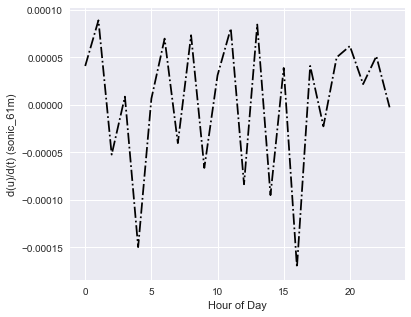

In [123]:
varName = 'd(u)/d(t) (sonic_61m)'

fig = plt.figure(figsize=(6,5))
ax  = fig.add_subplot(111)
ax.plot(diurnal_cycle[varName],'-.k')
ax.set_xlabel('Hour of Day')
ax.set_ylabel(varName)